### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime
import heapq
import xgboost as xgb
import h5py
from tqdm import tqdm_notebook as tqdm

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means

from cyclicLR_callback import CyclicLR

random_seed = 4321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.3'

In [3]:
import cv2
cv2.__version__

'3.3.1'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [4]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [5]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


### Load Data

In [6]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


### Missing values

In [8]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [5]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

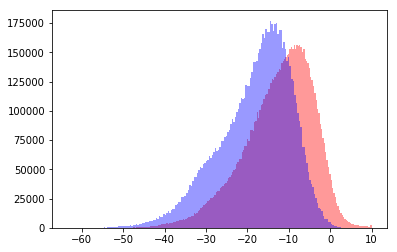

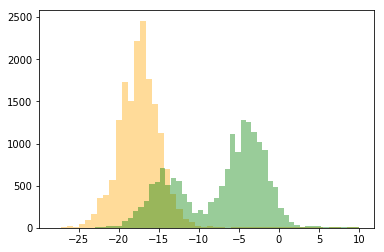

In [10]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

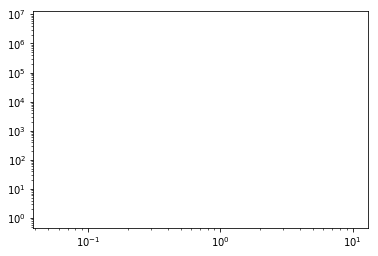

In [11]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

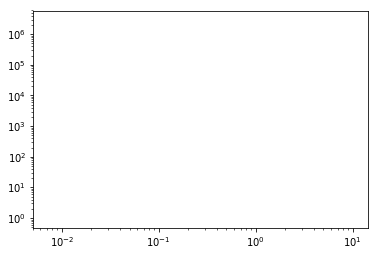

In [12]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

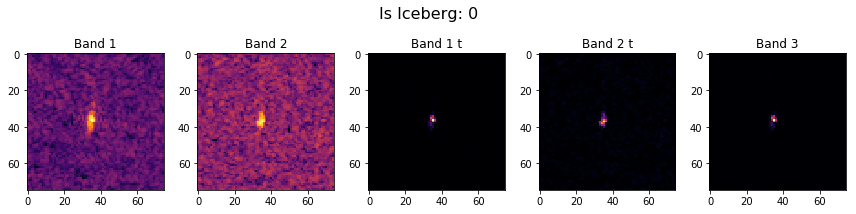

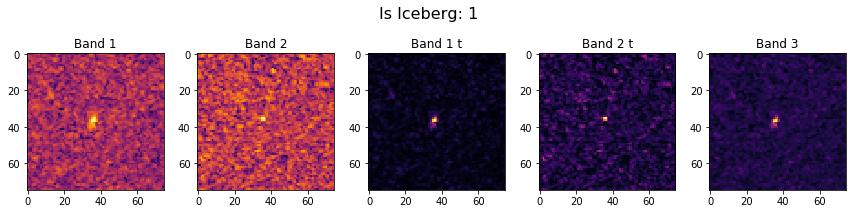

In [13]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [14]:
band_3[2].max()

8.4155418416635133

In [15]:
imgs = X[:3,:,:,:2].copy()
imgs.shape

(3, 75, 75, 2)

In [6]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [7]:
def add_noise(img, noise):
    rand_img = np.zeros(img.shape)
    cv2.randn(rand_img,noise[0],noise[1]) 
    return img + rand_img

In [18]:
X[:60,:,:,:2].copy().max()

10.000000000000002

In [19]:
imgs = X[:60,:,:,:2].copy()
apply_over_axis(add_noise, imgs, axis=0, noise=((1,0.5),(1,0.5))).max()

13.235153209793092

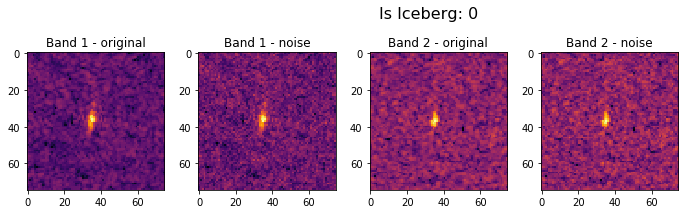

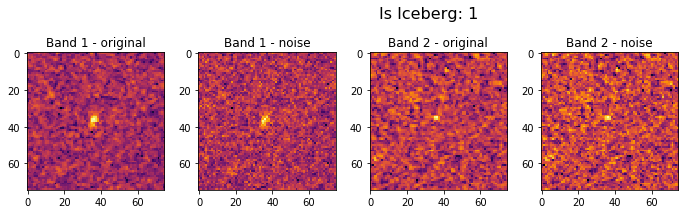

In [20]:
def plot_with_noise(index, cmap="gray"):
    m = (2) 
    s = (2)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1 - original")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 1 - noise")
    img = band_1[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax2.imshow(img, cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 2 - original")
    ax3.imshow(band_2[index], cmap=cmap)
    ax4 = fig.add_subplot(254)
    ax4.set_title("Band 2 - noise")
    img = band_2[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    m = (1) 
    s = (1)
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax4.imshow(img, cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_with_noise(0,cmap="inferno")
plot_with_noise(2,cmap="inferno")

In [21]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [22]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.35, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1042, 75, 75, 4)
(562, 75, 75, 4)


In [24]:
X_val_tune, X_val_test, y_val_tune, y_val_test = train_test_split(X_val, y_val, test_size=0.3, random_state=random_seed)
print(X_val_tune.shape)
print(X_val_test.shape)

(393, 75, 75, 4)
(169, 75, 75, 4)


### Data augmentation

In [25]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

(1042, 75, 75, 4)


In [8]:


datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator, noise=((1,1),(1,1))):
        self.imagegen = imagegen
        self.noise = noise
        self.noise_on = False
        
    def flow(self, x, y, batch_size=8, shuffle=True, noise_on = False, noise=((1,1),(1,1))):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        self.noise=noise
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        if self.noise_on:
            batches = temp_data[0][:,:,:,:4].copy()
            batches = apply_over_axis(add_noise, batches, axis=0, noise=noise)
            temp_stacked1 = batches
            temp_band_3 = batches[:,:,:,2] - batches[:,:,:,3] #band_1_t - band_2_t
        else:
            #temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
            temp_stacked1 = temp_data[0][:,:,:,:2]
            temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        #nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                #nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    



In [15]:

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

NameError: name 'X_train_sample' is not defined

### Learning rate scheduler and callback definition

In [9]:
# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001, drop=0.66, patience=5):
        self.initial_lrate=initial_lrate
        self.drop = drop
        self.patience = patience

    def step_decay(self,epoch):
        initial_lrate = self.initial_lrate
        drop = self.drop
        patience = self.patience
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

### Denoising

In [29]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [30]:
#X_denoised = apply_over_axis(denoising, X)

In [31]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [32]:
##custom generator for denoising
#from collections import Generator
#class Datagen_denoising(Generator):
#    def __init__(self, imagegen=ImageDataGenerator):
#        self.imagegen = imagegen
#        
#    def flow(self, x, y, batch_size=8, shuffle=True):
#        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
#        return self
#    
#    def send(self, ignored):
#        temp_data = next(self.generator)
#        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
#        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
#                                temp_data[0][:,:,:,3]),axis=3)
#        return temp_stacked, temp_stacked
#    
#    def throw(self, type=None, value=None, traceback=None):
#        raise StopIteration
#        
#datagen_denoising = Datagen_denoising(imagegen=datagen)
#datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [33]:
#m_input = Input(shape=(75,75,4), name='m_input')
#
##conv layers for main_input
#x1 = BatchNormalization()(m_input)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
#model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')
#
#model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
#loss='mean_squared_error',
#metrics=['mae'])

In [34]:
#model_denoise.summary()

In [35]:
##model training
##lScheduler_denoising = LScheduler(initial_lrate=0.1, drop=0.66, patience=3)
##lrScheduler_denoising = LearningRateScheduler(lScheduler_denoising.step_decay)
#lrScheduler_denoising = CyclicLR(base_lr=1e-8, max_lr=0.006,
#                                 step_size=400, mode='triangular2', gamma=0.99994)
#start_time = time.monotonic()
#
#H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
#                    steps_per_epoch=len(X)/8,
#                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
#                    validation_steps=len(X)/8,
#                    #validation_data=[X_val,y_val],
#                    epochs=12,
#                    callbacks = [lrScheduler_denoising, 
#                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
#                    verbose=0)
#
#model_time = time.monotonic() - start_time
#print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
#      + '{:.1f}'.format(model_time % 60) + " seconds")

In [36]:
#h = lrScheduler_denoising.history
#plt.plot(h['lr'], color="b", label='lr')
#plt.legend()
#plt.xlabel('# iterations')
#plt.show()

In [37]:
## serialize model to JSON
#model_json = model_denoise.to_json()
#with open("models/model_denoise.json", "w") as json_file:
#    json_file.write(model_json)

In [38]:
## serialize weights to HDF5
#model_weights = model_denoise.get_weights()
#with open('models/model_denoise_weights.pickle', 'wb') as handle:
#    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
## load json and create model
#with open("models/model_denoise.json", "r") as json_file:
#    loaded_model_json = json_file.read()
#model_denoise = model_from_json(loaded_model_json)
## load weights into new model
#with open('models/model_denoise_weights.pickle', 'rb') as handle:
#    model_weights = pickle.load(handle)
#model_denoise.set_weights(model_weights)
#print("Loaded model from disk")

In [40]:
#X_nn_denoised = model_denoise.predict(X, verbose=1)

In [41]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before band_1")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("NN Denoising band 1")
#ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
#ax3 = fig.add_subplot(253)
#ax3.set_title("Before band 2")
#ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax4 = fig.add_subplot(254)
#ax4.set_title("NN Denoising band 2")
#ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### Keras model

In [42]:
model_code="CNN_2018_01_22_v02"
model_comment="2 CNN inputs 3,3 conv filters, na=0"

In [43]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
#aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
#x3 = model_denoise(aux_input_nn)
#x3 = InputBlock(x3,dropout=0.3, prefix='a_input_nn')

#x = x1
x = Concatenate(axis=3)([x1,x2])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(512, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        #aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [44]:
%run -i current_model.py

In [10]:
class ModelHistory(Callback):
    def __init__(self, listSize=10):
        self.listSize = listSize
        self.models = []

    def on_epoch_end(self, epoch, logs={}):
        lastLoss = logs.get('val_loss')
        rank = 1 - lastLoss
        if len(self.models) > 0:
            if rank > self.models[0][0]: # new model is better than the worst in the heap
                if len(self.models) >= self.listSize: #if the model heap is already full
                    heapq.heappushpop(self.models, (rank, lastLoss, self.model.get_weights()))
                else:
                    heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))
        else:
            heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))

def get_callbacks(filepath, save_to_disc = True, lScheduler = None,
                  patience=10, step_decay=LScheduler().step_decay, modelHistoryCallback=None):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    if lScheduler is None:
        lrScheduler = LearningRateScheduler(step_decay)
    else:
        lrScheduler = lScheduler
    tqdmCallback =  TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    if (save_to_disc):
        return [msave, lrScheduler, modelHistoryCallback, tqdmCallback]
    else:
        return [lrScheduler, modelHistoryCallback, tqdmCallback]

In [46]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 2)    8           main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 75, 75, 3)    12          aux_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (

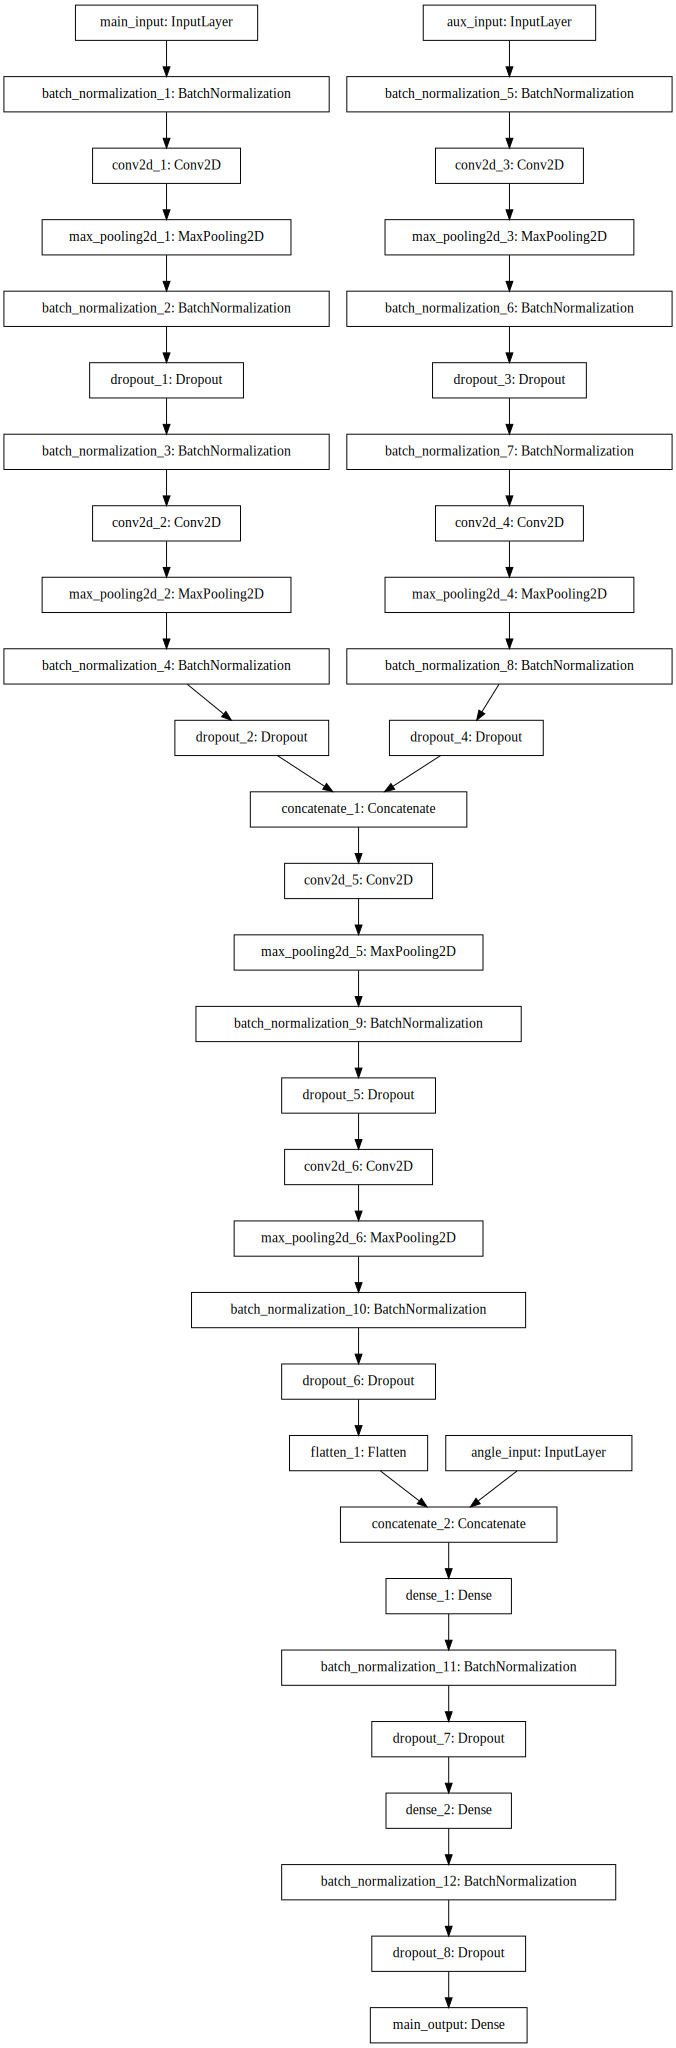

In [47]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [48]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
#lScheduler = LScheduler(initial_lrate=0.001, drop=0.66, patience=7)
modelEnsemble = ModelHistory(listSize=101)
lScheduler = CyclicLR(base_lr=0.001, max_lr=0.003,
                                 step_size=60, mode='triangular3', beta=0.22, theta=0.11)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble)

In [49]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=64, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), #add noise mean(4 channel) and sigma(4 channels)
                    steps_per_epoch=len(X_train_sample)/64,
                    validation_data=datagen_angle_val.flow(X_val_tune, y_val_tune, batch_size=40, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                    validation_steps=len(X_val)/40,
                    #validation_data=[X_val,y_val],
                    epochs=200, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Model training time: 52 minutes 51.8 seconds


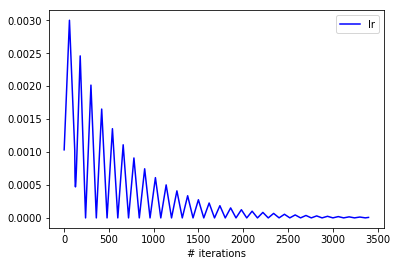

In [50]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

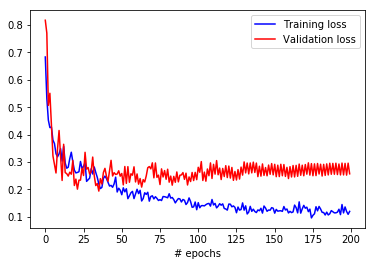

In [51]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [52]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])

### Additional training epochs  - warm start

In [53]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble2 = ModelHistory(listSize=1)
lScheduler = CyclicLR(base_lr=1e-7, max_lr=1e-5,
                                 step_size=60, mode='triangular3', beta=0.33, theta=0.22)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble2)
model_f.compile(optimizer=Adam(lr=1e-7),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=48, shuffle=True, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))),
                    steps_per_epoch=len(X_train_sample)/48,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=48, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                    validation_steps=len(X_val)/48,
                    #validation_data=[X_val,y_val],
                    epochs=15, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Model training time: 3 minutes 54.2 seconds


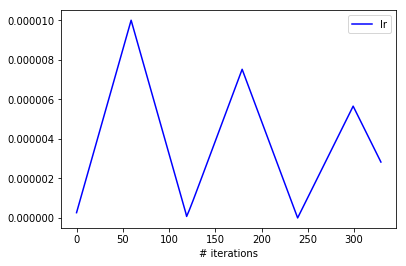

In [54]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [55]:
for key in H.history:
    H.history[key].extend(H2.history[key])

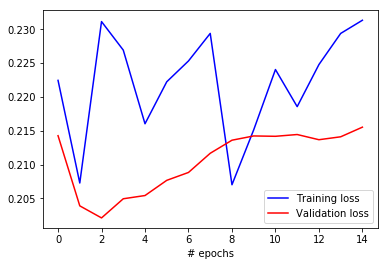

In [56]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

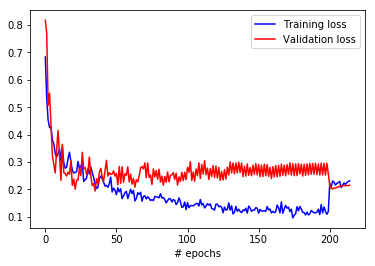

In [57]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [58]:
# serialize model to JSON
model_json = model_f.to_json()
with open("models/model_gcompute_v1.json", "w") as json_file:
    json_file.write(model_json)

In [11]:
# load model from JSON - don't care about the weights rith now, they are saved separately
with open("models/model_gcompute_v1.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_f = model_from_json(loaded_model_json)

In [60]:
#model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
#model_f.save('models/last_model.hdf5') //crashes python kernel with Keras version 2.1.2
#model_f = load_model(model_object_path)

### Saving model history

In [61]:
argmin = np.array(H.history["loss"]).argmin()
argmin

174

In [62]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
#with open('current_model.py','r') as model_python_code_file:
#    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
#                                    "val_loss [min]":[H.history['val_loss'][argmin]],
#                                    "epoch [val_loss [min]]":argmin,
#                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
#                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
#                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
#                                    
#                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
#                                    "epoch [val_acc [max]]":argmax_acc,
#                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
#                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
#                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
#                                    
#                                    "model_path":[model_object_path],
#                                    "model_weights_path":[model_best_weights_path],
#                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
#                                    "model_comment":[model_comment]
#                                })
#                               
#models_history = models_history[["timestamp", 
#                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
#                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
#                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
#                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
#                                 "model_path","model_weights_path","model_python_code","model_comment"]]
#models_history.head()

In [63]:
#print("Min validation loss epoch:")
#print("epoch: %d" %(argmin),
#      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
#      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
#     )
#print("Max validation accuracy epoch:")
#print("epoch: %d" %(argmax_acc),
#      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
#      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
#     )
#print("model comment:", model_comment)
#

In [64]:
#with open('models_history.csv', 'a') as f:
#    models_history.to_csv(f, header=False,index=False)
#    #models_history.to_csv(f, index=False)

In [65]:
#df = pd.read_csv('models_history.csv')
#df.tail()

### Model Ensemble

In [14]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])
model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])
model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=16, shuffle=True, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                           steps = len(X)/6)

NameError: name 'datagen_angle_val' is not defined

In [67]:
heapq.heappush(modelEnsemble.models, heapq.nlargest(1,modelEnsemble2.models)[0])

In [68]:
with open('models/modelEnsemble_gcompute_v27.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
modelEnsemble = ModelHistory(listSize=106)
with open('models/modelEnsemble_gcompute_v27.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

In [37]:
def get_prediction(model,weights, X, y):
    model.set_weights(weights)
    return model.predict_generator(datagen_angle_val.flow(X, y, batch_size=256, shuffle=False, 
                                             noise_on=True,noise=((1,0.5,1,0.5),(1,0.5,1,0.5))), 
                           steps = len(X)/255, verbose=1)

In [38]:
def get_ensemble_predictions(X, y, modelEnsemble):
    predictions = [get_prediction(model_f, model[2], X, y)[:X.shape[0]]
                   for model in tqdm(modelEnsemble.models)]    
    temp_array = np.array(predictions)
    del(predictions)
    temp_array = np.swapaxes(temp_array,0,1)
    temp_array = temp_array.reshape(temp_array.shape[0],temp_array.shape[1])
    return temp_array

In [72]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [73]:
modelEnsemble.models[0][1]

0.25738911519163171

In [74]:
ensemble_val = get_ensemble_predictions(X_val_tune, y_val_tune, modelEnsemble)
ensemble_val_test = get_ensemble_predictions(X_val_test, y_val_test, modelEnsemble)

A Jupyter Widget

2/1 [======================================] - 2s 921ms/step



A Jupyter Widget

1/0 [=============================================] - 1s 840ms/step



In [75]:
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val",  data=ensemble_val)
ensemble_val.shape

(393, 102)

In [76]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_val = hf['ensemble_val'][:]

In [77]:
ensemble_val.shape

(393, 102)

In [78]:
y_val.shape

(562, 3)

In [79]:
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val_test",  data=ensemble_val)
ensemble_val.shape

(393, 102)

In [80]:
def modelfit(alg, X, y , X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("n_estimators: %d" % cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("Log loss (Train): %f" % metrics.log_loss(y, dtrain_predprob))
    print("Log loss (Test): %f" % metrics.log_loss(y_test, dtest_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

In [81]:
#ensemble_train = get_ensemble_predictions(X_train, y_train, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_train",  data=ensemble_train)

In [82]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [83]:
#ensemble_train.shape

In [84]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

### Fine tuning ensemble using xgboost


Model Report
n_estimators: 42
Accuracy : 0.9949
Log loss (Train): 0.060636
Log loss (Test): 0.164816


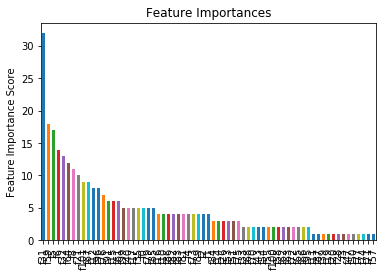

In [85]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])

In [86]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [98]:
param_test1 = {
 'max_depth':list(range(3,13,2)),
 'min_child_weight':list(range(1,10,2))
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=42, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch1.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.2s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.23581, std: 0.05974, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.22580, std: 0.05278, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.22487, std: 0.05761, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.22535, std: 0.05830, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.22487, std: 0.05356, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.23889, std: 0.05219, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.22704, std: 0.04811, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.22521, std: 0.05754, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.22535, std: 0.05830, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.22487, std: 0.05356, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.23699, std: 0.05092, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.22704, std: 0.04811, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.22521, std: 0.057

In [101]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[8.5,9,9.5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=42, max_depth=2,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch2.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.1s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22648, std: 0.05678, params: {'max_depth': 2, 'min_child_weight': 8.5},
  mean: -0.22487, std: 0.05356, params: {'max_depth': 2, 'min_child_weight': 9},
  mean: -0.22832, std: 0.05472, params: {'max_depth': 2, 'min_child_weight': 9.5},
  mean: -0.22648, std: 0.05678, params: {'max_depth': 3, 'min_child_weight': 8.5},
  mean: -0.22487, std: 0.05356, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.22832, std: 0.05472, params: {'max_depth': 3, 'min_child_weight': 9.5},
  mean: -0.22648, std: 0.05678, params: {'max_depth': 4, 'min_child_weight': 8.5},
  mean: -0.22487, std: 0.05356, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: -0.22832, std: 0.05472, params: {'max_depth': 4, 'min_child_weight': 9.5}],
 {'max_depth': 2, 'min_child_weight': 9},
 -0.22486825743789884)

In [102]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0,30)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=42, max_depth=2,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch3.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.9s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22487, std: 0.05356, params: {'gamma': 0.0},
  mean: -0.22487, std: 0.05356, params: {'gamma': 0.05},
  mean: -0.22583, std: 0.05516, params: {'gamma': 0.1},
  mean: -0.22632, std: 0.05545, params: {'gamma': 0.15},
  mean: -0.22632, std: 0.05545, params: {'gamma': 0.2},
  mean: -0.22631, std: 0.05551, params: {'gamma': 0.25},
  mean: -0.22622, std: 0.05564, params: {'gamma': 0.3},
  mean: -0.22759, std: 0.05518, params: {'gamma': 0.35},
  mean: -0.22840, std: 0.05550, params: {'gamma': 0.4},
  mean: -0.22861, std: 0.05569, params: {'gamma': 0.45},
  mean: -0.22861, std: 0.05569, params: {'gamma': 0.5},
  mean: -0.22852, std: 0.05575, params: {'gamma': 0.55},
  mean: -0.22842, std: 0.05560, params: {'gamma': 0.6},
  mean: -0.22874, std: 0.05543, params: {'gamma': 0.65},
  mean: -0.22881, std: 0.05545, params: {'gamma': 0.7},
  mean: -0.22939, std: 0.05640, params: {'gamma': 0.75},
  mean: -0.23008, std: 0.05636, params: {'gamma': 0.8},
  mean: -0.23178, std: 0.05850, params: 


Model Report
n_estimators: 77
Accuracy : 0.9364
Log loss (Train): 0.161308
Log loss (Test): 0.160444


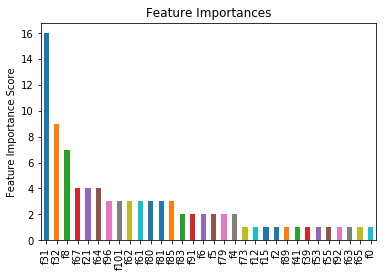

In [103]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=9,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, ensemble_val, y_val_tune['is_iceberg'],ensemble_val_test, y_val_test['is_iceberg'])

In [104]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=2,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch4.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.8s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.23730, std: 0.05915, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.23468, std: 0.05702, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.22313, std: 0.05467, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.22623, std: 0.05656, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.23854, std: 0.05545, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.23738, std: 0.05494, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.22532, std: 0.05655, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.22707, std: 0.05635, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.23620, std: 0.05274, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.23651, std: 0.05559, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.22428, std: 0.05462, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.22649, std: 0.05596, params: {'colsample_bytree': 0.8,

In [106]:
param_test5 = {
 'subsample':[i/100.0 for i in range(50,80,5)],
 'colsample_bytree':[i/100.0 for i in range(60,90,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=2,
 min_child_weight=9, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch5.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    6.4s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.24510, std: 0.05048, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.24071, std: 0.05481, params: {'colsample_bytree': 0.6, 'subsample': 0.55},
  mean: -0.23730, std: 0.05915, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.23175, std: 0.05528, params: {'colsample_bytree': 0.6, 'subsample': 0.65},
  mean: -0.23468, std: 0.05702, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.22678, std: 0.05747, params: {'colsample_bytree': 0.6, 'subsample': 0.75},
  mean: -0.24124, std: 0.05018, params: {'colsample_bytree': 0.65, 'subsample': 0.5},
  mean: -0.24033, std: 0.05392, params: {'colsample_bytree': 0.65, 'subsample': 0.55},
  mean: -0.23796, std: 0.05898, params: {'colsample_bytree': 0.65, 'subsample': 0.6},
  mean: -0.23328, std: 0.05522, params: {'colsample_bytree': 0.65, 'subsample': 0.65},
  mean: -0.23466, std: 0.05651, params: {'colsample_bytree': 0.65, 'subsample': 0.7},
  mean: -0.23027, std: 0.05593, params: {'colsample_byt

In [107]:
param_test6 = {
 'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=77, max_depth=2,
 min_child_weight=9, gamma=0.0, subsample=0.75, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch6.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22678, std: 0.05747, params: {'reg_alpha': 0},
  mean: -0.22678, std: 0.05747, params: {'reg_alpha': 1e-05},
  mean: -0.22551, std: 0.05768, params: {'reg_alpha': 0.01},
  mean: -0.22622, std: 0.05776, params: {'reg_alpha': 0.1},
  mean: -0.22914, std: 0.05895, params: {'reg_alpha': 1},
  mean: -0.69315, std: 0.00000, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 -0.22550816898411624)

In [110]:
param_test7 = {
 'reg_alpha':[1e-4, 1e-3, 0.003, 0.01, 0.03]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=77,max_depth=2,
 min_child_weight=9, gamma=0.0, subsample=0.75, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch7.fit(ensemble_val,y_val_tune['is_iceberg'].values)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.9s finished
/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.22678, std: 0.05747, params: {'reg_alpha': 0.0001},
  mean: -0.22689, std: 0.05765, params: {'reg_alpha': 0.001},
  mean: -0.22627, std: 0.05772, params: {'reg_alpha': 0.003},
  mean: -0.22551, std: 0.05768, params: {'reg_alpha': 0.01},
  mean: -0.22696, std: 0.05741, params: {'reg_alpha': 0.03}],
 {'reg_alpha': 0.01},
 -0.22550816898411624)


Model Report
n_estimators: 116
Accuracy : 0.9288
Log loss (Train): 0.165041
Log loss (Test): 0.164859


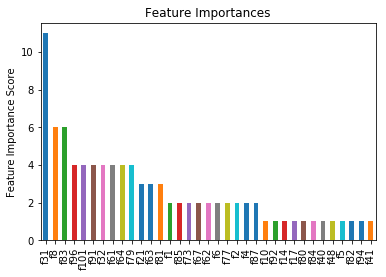

In [112]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=9,
 gamma=0.0,
 subsample=0.75,
 colsample_bytree=0.6,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 77
Accuracy : 0.9364
Log loss (Train): 0.161342
Log loss (Test): 0.160440


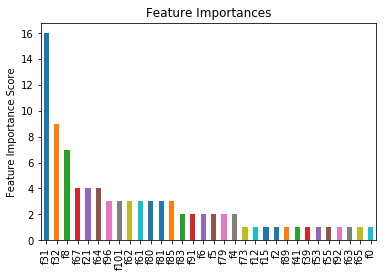

In [137]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=9,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_val, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])

In [143]:
dtest_predprob = xgb4.predict_proba(ensemble_val_test)[:,1]
    
#Print model report:
print("\nModel Report")
print("Log loss (Test): %f" % metrics.log_loss(y_val_test['is_iceberg'], dtest_predprob))


Model Report
Log loss (Test): 0.160440


In [144]:
with open('models/modelXgb4_gcompute_v27.pickle', 'wb') as handle:
    pickle.dump(xgb4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('models/modelXgb4_gcompute_v27.pickle', 'rb') as handle:
    xgb4 = pickle.load(handle)

### Predictions

In [ ]:
#use model
#model_object_path = "models\\model.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"
#model_best_weights_path = "models\\weights.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"

In [ ]:
#model_f = load_model(model_object_path)

In [ ]:
#model_f.load_weights(model_best_weights_path)

In [ ]:
#model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                          steps = len(X_val)/32)

In [17]:
test_df = pd.read_json("Data/test/test.json")

In [18]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [19]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())
test_df['inc_angle_f'].replace(np.nan,0, inplace=True)
test_df.tail()

missing values in inc_angle:  0


,band_1,band_2,id,inc_angle,inc_angle_f
8419,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",16ee9b50,34.795500,34.795500
8420,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",5a599eb7,32.246683,32.246683
8421,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",df30d6dd,39.503200,39.503200
8422,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",18af95b1,33.638000,33.638000
8423,"[-25.438865661621094, -25.438865661621094, -25...","[-23.85527801513672, -23.85527801513672, -23.8...",27d788c8,36.758181,36.758181


In [20]:
_, _, _, _, _, X_test = get_bands(test_df)
y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle_test['index'] = y_angle_test.index

/home/marozet2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/marozet2/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [21]:
X_test.shape

(8424, 75, 75, 4)

In [22]:
datagen_val.fit(X_test)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

In [151]:
idx = 0
pred = get_prediction(model_f, modelEnsemble.models[idx][2], X_test, y_angle_test)[:X_test.shape[0]]
pred = np.array(pred)
dataset_name = 'ensemble_data_%02d' % idx
with h5py.File('tmp_data/ensemble_test_data.hd5', 'w') as hf:
    hf.create_dataset(dataset_name,  data=pred)
idx=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

34/33 [==============================] - 40s 1s/step


A Jupyter Widget

34/33 [==============================] - 40s 1s/step



In [51]:
idx2=101
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test = [hf['ensemble_data_%02d' % idx2][:]]

In [39]:
#idx+=1
idx=37
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

A Jupyter Widget

34/33 [==============================] - 40s 1s/step



In [40]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

A Jupyter Widget

34/33 [==============================] - 41s 1s/step



In [41]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

A Jupyter Widget

34/33 [==============================] - 41s 1s/step


IndexError: list index out of range

In [ ]:
idx += 1
for i in tqdm(range(idx,len(modelEnsemble.models)), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
#ensemble_test = get_ensemble_predictions(X_test, y_angle_test, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_test",  data=ensemble_train)

In [52]:
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test_list = [hf['ensemble_data_%02d' % idx2][:] for idx2 in tqdm(range(0,len(modelEnsemble.models)), ascii=True)]

A Jupyter Widget

In [53]:
ensemble_test = np.array(ensemble_test_list)
ensemble_test = np.swapaxes(ensemble_test,0,1)
ensemble_test = ensemble_test.reshape(ensemble_test.shape[0],ensemble_test.shape[1])
ensemble_test.shape

(8424, 102)

In [54]:
with open('models/modelXgb4_gcompute_v27.pickle', 'rb') as handle:
    xgb4 = pickle.load(handle)

In [55]:
test_probs = xgb4.predict_proba(ensemble_test)
predictions = test_probs

In [56]:
predictions[:,1]

array([ 0.0389389 ,  0.02314228,  0.02314228, ...,  0.02314228,
        0.9648788 ,  0.02314228], dtype=float32)

In [57]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:,1]})
submission.head(10)
submission.to_csv("submission.ensemble.xgboost.106.v27.csv", index=False)